# Modelling Significant Wave Height
### Author: Yajun Zhou
#### Edits: Johnny Barrett

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

import plotly.express as px
import plotly.io as pio
from plot_template import theme

pd.options.plotting.backend = 'plotly'
pio.renderers.default = 'png'
px.defaults.height = 650
px.defaults.width = 1000
px.defaults.template = 'plotly_dark'
colours = px.colors.qualitative.Plotly

In [2]:
def show(plot, h=650, w=1000):
    plot = theme(plot)
    plot.show(height=h, width=w)

# 1  EDA

The first step is to extract the hour, day, and month from the time series data. Then use the four-time periods of each day; Upper, middle and lower part of each month; and the four quarters of each year as bin, to divide the time continuous variable into category variables.

In [3]:
df = pd.read_csv('../ocean-waves-full.csv', parse_dates=['DateTime'])

In [4]:
time_series = df['DateTime']
df['month'] = time_series.dt.month
df['day'] = time_series.dt.day
df['hour'] = time_series.dt.hour

del df['DateTime']
del df['CottPeakPeriod']
del df['CottDirection']

order = ['month', 'day', 'hour', 'RottHeight', 'RottPeakPeriod', 'RottDirection', 'CottHeight']
df = df[order]
print(df.describe())

              month           day          hour    RottHeight  RottPeakPeriod  \
count  60242.000000  60242.000000  60242.000000  60242.000000    60242.000000   
mean       6.123701     15.756150     11.490206      2.203048       12.632231   
std        3.447944      8.764956      6.918700      0.945008        2.589587   
min        1.000000      1.000000      0.000000      0.500000        2.941176   
25%        3.000000      8.000000      5.000000      1.570000       11.111111   
50%        6.000000     16.000000     11.000000      1.990000       12.500000   
75%        9.000000     23.000000     17.000000      2.570000       14.285714   
max       12.000000     31.000000     23.000000      8.660000       28.571429   

       RottDirection    CottHeight  
count   60242.000000  60242.000000  
mean      249.977103      1.004892  
std        16.324936      0.460708  
min         1.406250      0.190000  
25%       244.687500      0.690000  
50%       250.312500      0.890000  
75%       2

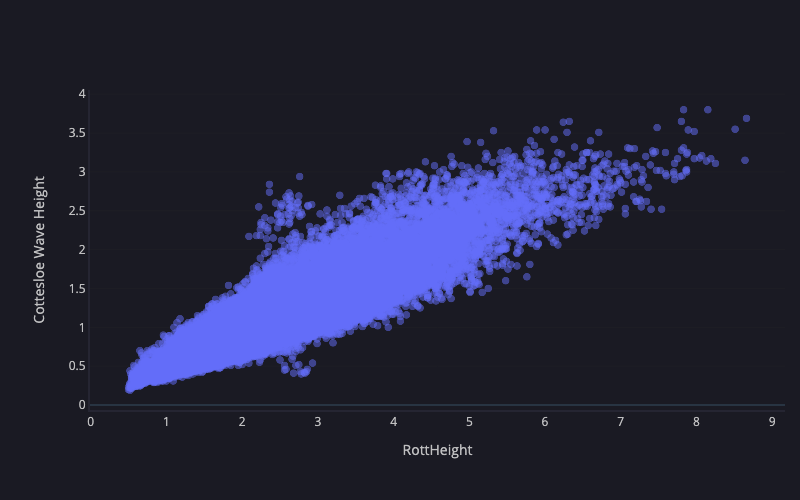

In [16]:
labels = {'RottPeakPeriod': 'Rottnest Peak Period',
          'CottHeight': 'Cottesloe Wave Height'}

p = px.scatter(df, 'RottHeight', 'CottHeight', opacity=0.5, labels=labels)
show(p, h=500, w=800)

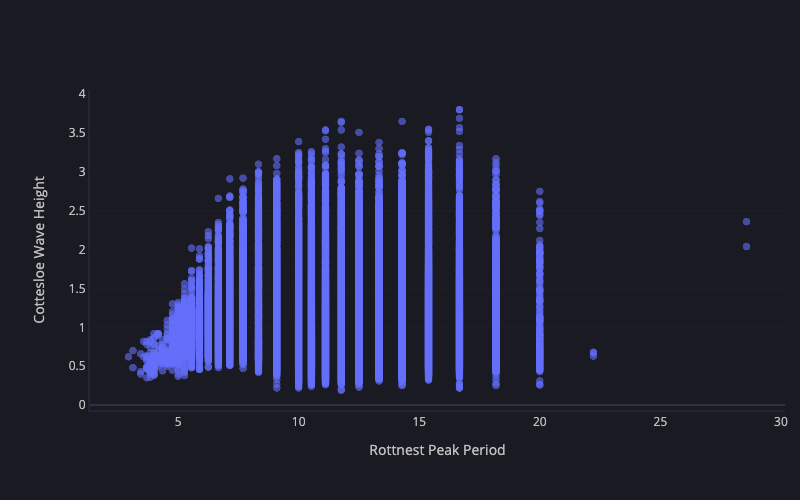

In [17]:
p = px.scatter(df, 'RottPeakPeriod', 'CottHeight', opacity=0.6, labels=labels)
show(p, h=500, w=800)

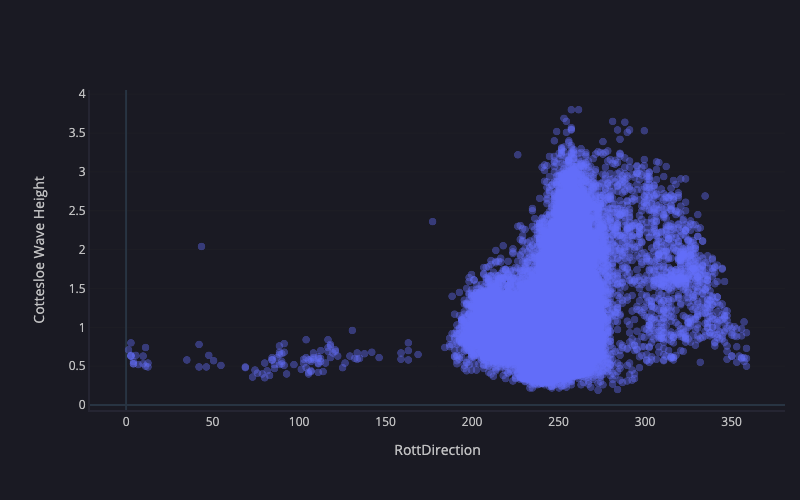

In [19]:
p = px.scatter(df, 'RottDirection', 'CottHeight', opacity=0.4, labels=labels)
show(p, h=500, w=800)

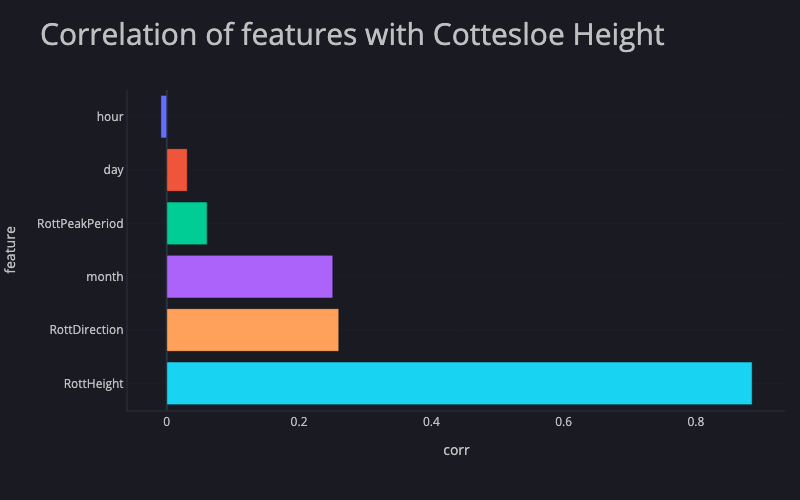

In [26]:
# Check correlation of every feature with target
features = ['month', 'day', 'hour', 'RottHeight', 'RottPeakPeriod', 'RottDirection']
spr = pd.DataFrame()
spr['feature'] = features
spr['corr'] = [round(df[f].corr(df['CottHeight'], 'spearman'), 3) for f in features]

spr = spr.sort_values('corr')
p = px.bar(spr, x='corr', y='feature', orientation='h', color='feature',
           title='Correlation of features with Cottesloe Height',
           ).update_traces(showlegend=False)
show(p, h=500, w=800)

In [5]:
# use bin method to treat time feature as category variable
# After applying to the model, we found that the "bins of hour" almost has no effect on the model result,
# so we remove it to reduce dimension in case of overfitting. 

bins_of_month = [0, 4 ,7, 9, 13]
df['month'] = pd.cut(df['month'], bins_of_month, labels=[1, 2, 3, 4])

bins_of_day = [0, 10 ,20, 32]
df['day'] = pd.cut(df['day'], bins_of_day, labels=[1, 2, 3])

del df['hour']

print(df.describe())

         RottHeight  RottPeakPeriod  RottDirection    CottHeight
count  60242.000000    60242.000000   60242.000000  60242.000000
mean       2.203048       12.632231     249.977103      1.004892
std        0.945008        2.589587      16.324936      0.460708
min        0.500000        2.941176       1.406250      0.190000
25%        1.570000       11.111111     244.687500      0.690000
50%        1.990000       12.500000     250.312500      0.890000
75%        2.570000       14.285714     257.343750      1.180000
max        8.660000       28.571429     358.593750      3.800000


In [6]:
# use OneHot Encoding to make all values of the categorical features are equally away from each other,
# and it help to avoid the overfitting caused by the gradient descent in high dimension.
col_names = ['month','day']
for col in col_names:
    OnehotEn = pd.get_dummies(df[col], prefix=col)
    df.drop([col], axis=1, inplace=True)
    df = pd.concat([df, OnehotEn], axis=1)


# normalise numerical feature to make the model faster to find the optimal solution during training
z_scaler = lambda x : (x - np.mean(x)) / np.std(x)
df_ = df[['RottHeight', 'RottPeakPeriod', 'RottDirection']].apply(z_scaler)

del df['RottHeight']
del df['RottPeakPeriod']
del df['RottDirection']

df = pd.concat([df,df_],axis=1)
label_y = df['CottHeight']
df.drop(['CottHeight'], axis=1, inplace=True)
print(df.describe())

            month_1       month_2       month_3       month_4         day_1  \
count  60242.000000  60242.000000  60242.000000  60242.000000  60242.000000   
mean       0.366057      0.279888      0.139056      0.215000      0.325520   
std        0.481729      0.448948      0.346008      0.410825      0.468573   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              day_2         day_3    RottHeight  RottPeakPeriod  RottDirection  
count  60242.000000  60242.000000  6.024200e+04    6.024200e+04   6.024200e+04  
mean       0.331480      0.343000  3.396904e-16   -1.094558e-16   5.736994e-16  
std        0.470749      0.474715  1.000008e+

___
# 2 Model Training

**Model evaluation**:
- Gridsearch and Cross-validation are used to fine-tune to find the optimal hyperparameters
- Then use the optimal parameters of each model to obtain the final result in the test set

In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [15]:
# train_test splitting
X_train, X_test, y_train, y_test = train_test_split(df, label_y, test_size=0.2, random_state=11)

## 2.1 Ridge Regressor

Ridge regression is a linear regression plus regularisation of the weight L2 norm. Ridge regression is also a linear model for regression, so its prediction formula is the same as the ordinary least squares method. But in ridge regression, the choice of coefficient ($w$) not only needs to obtain good prediction results on the training data but also fits additional constraints. At the same time, we also hope that the coefficients are as small as possible (all elements of $w$ are as close to zero as possible), while still giving good prediction results. This constraint is an example of normalisation.

In [110]:
alpha = [0.1,0.5,1.0,2.0,5.0,10.0,15.0]
param_grid = dict(alpha=alpha)
kfold = KFold(n_splits=10, shuffle=True)
model = Ridge()
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold,verbose=True)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
y_pred_test = grid_search.best_estimator_.predict(X_test)
print("MSE of Ridge Regression prediction for Test Data = %f" % mean_squared_error(y_pred_test,y_test))
print("MAPE of Ridge Regression prediction for Test Data = %f" % mape(y_pred_test,y_test), '%')

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best: -0.032334 using {'alpha': 2.0}
MSE of Ridge Regression prediction for Test Data = 0.031396
MAPE of Ridge Regression prediction for Test Data = 14.009404 %


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.2s finished


In [ ]:
p = px.scatter(x=y_test, y=y_pred_test, opacity=0.7,
               labels={'x': 'Cottesloe Wave Height',
                       'y': 'Predicted Cottesloe Wave Height'},
               title='Ridge Regressor Predictions vs True')\
        .update_traces(marker_color=colours[5])
show(p)

![ridge](img/ridge.png)

## 2.2 KNN

When using KNN for regression, we choose the averaging method, that is, the average value of the sample output of the nearest K samples as the regression prediction value.

In [122]:
model = KNeighborsRegressor()
kfold = KFold(n_splits = 5, shuffle = True)
n_neighbors = [5,6,7,8,9,10,20]
param_grid = {"n_neighbors": n_neighbors}
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold, verbose=True)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
Y_pred_test = grid_search.best_estimator_.predict(X_test)
print("MSE of lodNN prediction for Test Data = %f" % mean_squared_error(Y_pred_test,y_test))
print("MAPE of KNN prediction for Test Data = %f" % mape(Y_pred_test,y_test), '%')

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   12.9s finished


Best: -0.027152 using {'n_neighbors': 20}
MSE of KNN prediction for Test Data = 0.026364
MAPE of KNN prediction for Test Data = 12.289897 %


In [ ]:
p = px.scatter(x=y_test, y=y_pred_test, opacity=0.7,
               labels={'x': 'Cottesloe Wave Height',
                       'y': 'Predicted Cottesloe Wave Height'},
               title='KNN Regressor Predictions vs True')\
        .update_traces(marker_color=colours[9])
show(p)

![knn](img/knn.png)

## 2.3 Gradient Boosting Decision Trees

Ensemble learning integrates multiple (potentially poor quality) machine learning algorithms into a strong learner. Gradient Boosting Decision Trees are a modern take on the Random Forest: a large group (ensemble) of Decision Trees who's individual predictions are aggregated into a single prediction for each data point. Gradient Boosting Decision Trees add to this method, wherein each tree learns the residual (negative gradient) of the sum of all the *previous* tree results. `LightGBM` is an implementation of such an algorithm, and can be used for both regression and classification tasks. Random Forests are already well known for their wide array of hyperparameters that can be used to regularise the model fit, and the gradient boosting capabilities of`LightGBM` only make this list longer. Here we perform a 5-fold cross-validation grid search over a sample of these, to find a suitable model configuration.

In [60]:
model = lgb.LGBMRegressor(objective='regression', random_state=11, importance_type='gain')
lold = KFold(n_splits=5, shuffle=True)

param_grid = dict(
    learning_rate=[0.01,0.1,0.2],
    num_leaves=[30,50],
    n_estimators=[200,500],
    colsample_bytree=[0.5,0.9,1.0]
)

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=kfold, verbose=True, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.6min finished


In [127]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

y_pred_train = best_model.predict(X_train)
print("MSE of LightGBM prediction for Train Data = %f" % mean_squared_error(y_pred_train, y_train))
print(f"r2 of LightGBM prediction for Train Data = {round(best_model.score(X_train, y_train), 5)}")
print("MAPE of LightGBM prediction for Train Data = %f" % mape(y_pred_train, y_train), '%')

y_pred_test = best_model.predict(X_test)
print("MSE of LightGBM prediction for Test Data = %f" % mean_squared_error(y_pred_test, y_test))
print(f"r2 of LightGBM prediction for Test Data = {round(best_model.score(X_test, y_test), 5)}")
print("MAPE of LightGBM prediction for Test Data = %f" % mape(y_pred_test, y_test), '%')

Best: -0.026335 using {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
MSE of LightGBM prediction for Train Data = 0.022026
r2 of LightGBM prediction for Train Data = 0.89564
MAPE of LightGBM prediction for Train Data = 11.415065 %
MSE of LightGBM prediction for Test Data = 0.025527
r2 of LightGBM prediction for Test Data = 0.88236
MAPE of LightGBM prediction for Test Data = 12.024416 %


In [ ]:
p = px.scatter(x=y_test, y=y_pred_test, opacity=0.7,
               labels={'x': 'Cottesloe Wave Height',
                       'y': 'Predicted Cottesloe Wave Height'},
               title='LightGBM Predictions vs True')\
        .update_traces(marker_color=colours[5])
show(p)

![lightgbm](img/lightgbm.png)

## Feature importances for LightGBM
One of the fantastic features of decision tree based models is the ability to directly and interpretably uncover the relative importance of each input feature. There are a number of ways to measure this importance, but here we measure it using the total *information gain* of each feature across the inidvidual trees.

In [46]:
def get_feature_importances(model, train):
    imprt = model.feature_importances_
    imprt_total = imprt.sum()
    return pd.DataFrame(dict(
        feature=train.columns,
        importance=imprt / imprt_total
    )).sort_values('importance', ascending=False)

In [47]:
def sum_cat_importances(ftr_imprt_df):
    return ftr_imprt_df.groupby(
        ftr_imprt_df['feature'].apply(lambda x: x.split('_')[0])
    ).sum().reset_index().sort_values('importance', ascending=False)

In [70]:
ftr_imprt = get_feature_importances(best_model, X_train)
ftr_imprt_cats = sum_cat_importances(ftr_imprt).sort_values('importance')
ftr_imprt_cats['importance'] = round(ftr_imprt_cats['importance'], 3)

In [ ]:
p = px.bar(ftr_imprt_cats, 'importance', 'feature', orientation='h',
           title='Feature Importances for LightGBM model', text='importance')
show(p)

<img src="img/lightgbm_fi.png" style="max-width: 900px">

Here we see that Rottnest Significant Wave Height accounts for **over 90%** of the information gain in our model. This is unsurprising, as we saw earlier how correlated this variable is with Cottesloe wave height.

___
# 3  Conclusion

Overall, and by both MSE and MAPE, the model that performed best on both the train and testing datasets was the Gradient Boosting Decision Trees method: ***LightGBM***, though its advantage over the KNN method is only slight.

### Comparison of model error scores

<img src="img/height-res.png" style="max-width: 800px">

This model, along with the others, displayed similar metric scores on the training and testing sets, suggesting a lack of overfitting.

___

![pred](img/height-pred.png)

![pred](img/height-pred2.png)